In [1]:
# Show cell execution time
%load_ext autotime

In [2]:
# import logging
# logging.basicConfig(filename='/var/panoptes/logs/pipeline.log')
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logger.info("Hi")

time: 428 µs


In [3]:
import os
from glob import glob
import h5py
import numpy as np
import pandas as pd

from IPython import display
from matplotlib import pyplot as plt
import matplotlib.offsetbox as offsetbox

from astropy.modeling import models, fitting
from astropy.time import Time
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.nddata.utils import Cutout2D, PartialOverlapError, NoOverlapError
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c

from matplotlib import pyplot as plt
plt.style.use('bmh')

import batman

from dateutil.parser import parse as date_parse
from tqdm import tqdm_notebook

from piaa.exoplanets import Exoplanet
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils import pipeline
from piaa.utils import postgres as db
from pocs.utils.images import fits as fits_utils

time: 4.21 s


In [4]:
catalog_cursor = db.get_cursor(db_name='v6', db_user='postgres', port=5433)

time: 245 ms


# Observation setup

Set up information about the observation sequence. Here we are working with files that have previosly been downloaded so we are using a local directory.

In [5]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Wasp80/14d3bd/20180609T095151/'

time: 551 µs


In [6]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits*')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 128 FITS files
time: 7.01 ms


## Lookup point sources

By default the first image will be passed to `sextractor` for basic point source detection. This image will then be catalog matched to the TESS (v6) catalog for source identification.

See `pipeline.lookup_point_sources?` for options.

In [7]:
# Lookup the point sources

ps_path = os.path.join(base_dir, 'sources.csv')

# try:
#     point_sources = pd.read_csv(ps_path, index_col=['id'])
# except FileNotFoundError:
point_sources = pipeline.lookup_point_sources(
    fits_files[0], 
    cursor=catalog_cursor,
    force_new=True,
    verbose=True,
#         method='photutils',
#     catalog_match=False
)
point_sources.to_csv(ps_path)

print("Found {} sources".format(len(point_sources)))

point_sources_phot = pipeline.lookup_point_sources(
    fits_files[0], 
    cursor=catalog_cursor,
    force_new=True,
    verbose=True,
    method='photutils',
#     catalog_match=False
)

print("Found {} sources".format(len(point_sources_phot)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Found 1034 sources


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Found 715 sources
time: 40.8 s


In [8]:
# Show top entries
point_sources.head()

,ra,dec,x,y,x_image,y_image,background,flux_best,fluxerr_best,mag_best,...,flux_aper,fluxerr_aper,mag_aper,magerr_aper,flux_max,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec
picid,,,,,,,,,,,,,,,,,,,,,
10777186,297.767960,27.716880,448,2142,447.7061,2142.1719,3231.971,30788.46,2257.431,13.7790,...,22732.92,1577.937,14.1084,0.0754,3076.094,6.95,0,7.628,7.58872,5.655294
10883789,297.755282,26.813254,766,2149,766.2598,2148.8264,3299.973,13486.62,1649.770,14.6752,...,13376.79,1575.959,14.6841,0.1279,2455.175,4.56,0,7.077,8.14900,7.799772
11027938,297.727150,24.627367,1533,2164,1533.3717,2164.3020,3357.790,57670.23,2569.349,13.0976,...,42759.13,1582.162,13.4224,0.0402,6737.298,3.76,0,7.442,7.43070,5.443080
11036706,297.869000,24.322085,1640,2120,1640.6381,2120.0442,3208.968,23133.84,2236.825,14.0894,...,15624.50,1577.544,14.5155,0.1096,2586.156,2.02,0,7.629,8.67000,5.190274
11133818,297.903248,26.226025,973,2104,973.2496,2104.0847,3332.072,52708.25,3299.416,13.1953,...,36888.30,1583.137,13.5828,0.0466,4101.782,5.93,0,7.542,7.48000,5.941396


time: 33.7 ms


In [9]:
s0 = set(point_sources.index.values)
s1 = set(point_sources_phot.index.values)

time: 1.76 ms


In [10]:
both_sets = s0.intersection(s1)

time: 1.08 ms


In [11]:
both_sources = point_sources.loc[list(both_sets)]

time: 3.92 ms


In [12]:
both_sources.head()

,ra,dec,x,y,x_image,y_image,background,flux_best,fluxerr_best,mag_best,...,flux_aper,fluxerr_aper,mag_aper,magerr_aper,flux_max,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec
picid,,,,,,,,,,,,,,,,,,,,,
263221250,298.658474,23.438556,1951,1869,1951.0160,1869.4464,3563.321,6816.458,1357.282,15.4161,...,7885.835,1571.460,15.2579,0.2164,2704.909,2.10,0,7.478,8.64000,5.570476
388448267,300.295292,15.210112,4832,1323,4831.4678,1322.4999,3293.130,24422.350,2095.635,14.0305,...,19417.470,1578.345,14.2795,0.0883,2747.036,6.67,0,7.842,8.10600,4.795741
395528204,302.645830,20.946220,2808,571,2808.4556,570.7103,3148.648,27581.300,1652.616,13.8985,...,27088.870,1581.072,13.9180,0.0634,4426.738,3.04,0,6.939,8.09900,5.330884
244985869,302.298659,27.647590,461,733,461.2353,732.7496,3100.600,6784.208,1800.645,15.4213,...,6036.617,1575.517,15.5480,0.2834,1169.890,2.66,0,7.399,8.87800,9.520151
215498770,295.054307,26.994343,684,2994,684.4846,2993.6025,3178.302,55435.750,2765.893,13.1405,...,36946.620,1577.612,13.5811,0.0464,5070.347,6.05,0,7.366,7.32581,7.000362


time: 32.4 ms


## Target Information

Lookup information about HD-189733. We use the 2mass ID to query the TESS catalog to get to get the ID, which we refer to as the PANOPTES Input Cataog ID (PICID). _(The PANOPTES catalog is basically the TESS catalog.)_

In [13]:
##### NOTE #####
# If you run this cell you get a random star in the same field.
# You should either run this cell or the one below.
##### END NOTE #####

# Pick a random target with high SNR and decent FWHM.


picid = str(point_sources[np.logical_and(
    point_sources.flags == 0,
    point_sources.fwhm < 5
)].sort_values(['snr', 'fwhm'], ascending=False).index[np.random.randint(10)])

# picid = str(point_sources[np.logical_and(
#     point_sources.vmag >= 7,
#     point_sources.vmag <= 8
#     np.logical_and(
#         abs(point_sources.roundness1) <= 0.5,
#         abs(point_sources.roundness2) <= 0.5,
#     ),
#     point_sources.peak >= 3000
# )].index[np.random.randint(10)])

print("PICID: {}".format(picid))

PICID: 392269792
time: 7.54 ms


In [14]:
# twomass = '20004297+2242342'
twomass = '20004370+2242391'

# Lookup 
picid = str(helpers.get_star_info(twomass_id=twomass, cursor=catalog_cursor).id)   # HD 189733
# picid = str(helpers.get_star_info(twomass_id='20124017-0208391')[0]) # Wasp 80
picid

'256364928'

time: 51.1 ms


In [15]:
point_sources.loc[int(picid)]

x                        2204.69
y                        1379.59
ra                       300.182
dec                      22.7091
background                3203.3
flux_auto                52207.9
flux_max                 5327.62
fluxerr_auto             1993.78
fwhm                        3.62
flags                          0
snr                      26.1854
twomass         20004370+2242391
tmag                     6.81314
vmag                        7.67
d2d                  0.000871006
Name: 256364928, dtype: object

time: 4.71 ms


In [16]:
# display.IFrame("https://exofop.ipac.caltech.edu/tess/target.php?id={}".format(picid), 1200, 400)

time: 421 µs


## Create PSC for all sources

Loop through all the detected sources and create a Postage Stamp Cube (PSC) for each source.

These PSC are saved in one HDF5 file named after the observation sequence.

Each PSC is $N \times M$, where $N$ is the number of frames in the sequence and $M$ is the squared-size of the side of the postage stamp (i.e. width * height, or a flattened array). A stamp will always be square and will have a red pixel in the top-right corner. The stamp size should always be an odd multiple of superpixels (2x2 - RGGB), e.g. 3,5,7 => 3x2=6, 5x2=10, 7x2=14.

> Note: Sources with any `flags` are filtered as well as $vmag < 14$

In [17]:
# Lookup the sequence (for filename)
sequence = fits_utils.getval(fits_files[0], 'SEQID')
sequence

'PAN012_358d0f_20180822T035809'

time: 6.88 ms


In [18]:
# Stamp size should be much larger than source. See above
# stamp_size = (14, 14)
stamp_size = (10, 10)
# stamp_size = (6, 6)

time: 624 µs


_Note: Process below can be long-running the first time. Subsequent runs just return HDF5 file (unless `force__new=True`)._

In [19]:
# Create stamps
stamps_fn = pipeline.create_stamp_slices(
    base_dir,
    fits_files,
    point_sources,
    stamp_size=stamp_size,
    force_new=False,
    verbose=True,
    notebook=True
)
stamps_fn

'/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/PAN012_358d0f_20180822T035809.hdf5'

time: 10.6 ms


In [20]:
# Get all the PSC for the observation sequence.
stamps = h5py.File(stamps_fn)
stamps

<HDF5 file "PAN012_358d0f_20180822T035809.hdf5" (mode r+)>

time: 4.01 ms


## Info about Observation and Exoplanet Transit

Get the image times and airmass information. There is currently a [bug](https://github.com/panoptes/POCS/issues/503) with the `DATE-OBS` keyword so we use the filename of the image to generate the timestamps. Otherwise the times would be stored in the `image_times` attribute of the stamps file.

The `airmass` also comes from an attribute.

In [21]:
# Get image times from filename
# image_times = [Time(
#     date_parse(os.path.splitext(fn.split('/')[-1])[0]) # .split('_')[4]
# ).datetime
# for fn in fits_files if 'pointing' not in fn]

image_times_mjd = stamps.attrs['image_times'] # MJD
image_times = [Time(t0, format='mjd').datetime for t0 in image_times_mjd]

airmass = stamps.attrs['airmass'][:]

time: 34.7 ms


With the `image_times` we are able to find if there is a transit overlap by looking
up the nearest transit to the image time.

In [22]:
exoplanet = Exoplanet('HD 189733 b')
# exoplanet = Exoplanet('Wasp-80 b')

transit_info = exoplanet.get_transit_info(Time(image_times[0]))

ingress = transit_info.ingress.datetime
midpoint = transit_info.midpoint.datetime
egress = transit_info.egress.datetime

time: 5.44 s


Plot the airmass alongside the transit information.

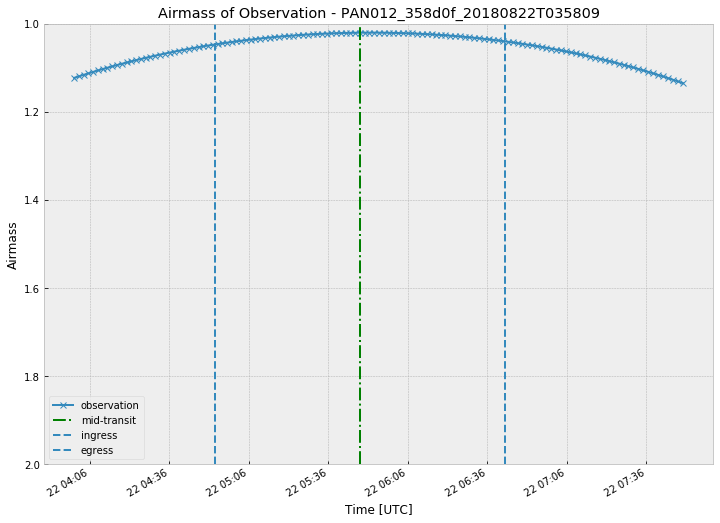

time: 531 ms


In [23]:
pd.Series(airmass, index=image_times).plot(figsize=(12, 9), marker='x', label='observation')

plt.gca().set_ylim([1, 2])
plt.gca().invert_yaxis()
plt.ylabel('Airmass')
plt.xlabel('Time [UTC]')

plt.title('Airmass of Observation - {}'.format(sequence))

try:
    plt.axvline(midpoint, label='mid-transit', ls='-.', c='g')
    plt.axvline(ingress, label='ingress', ls='--')
    plt.axvline(egress, label='egress', ls='--')
except NameError:
    pass

plt.legend()
plt.savefig('/var/panoptes/images/temp/PAN012/airmass_with_transit.png')

## Target PSC

Lookup the target coordinates and check target drift over the course of the observation.

In [24]:
# Lookup target coordinates
target_coords = SkyCoord(point_sources.loc[int(picid)].ra * u.deg, point_sources.loc[int(picid)].dec * u.deg)

time: 4.17 ms


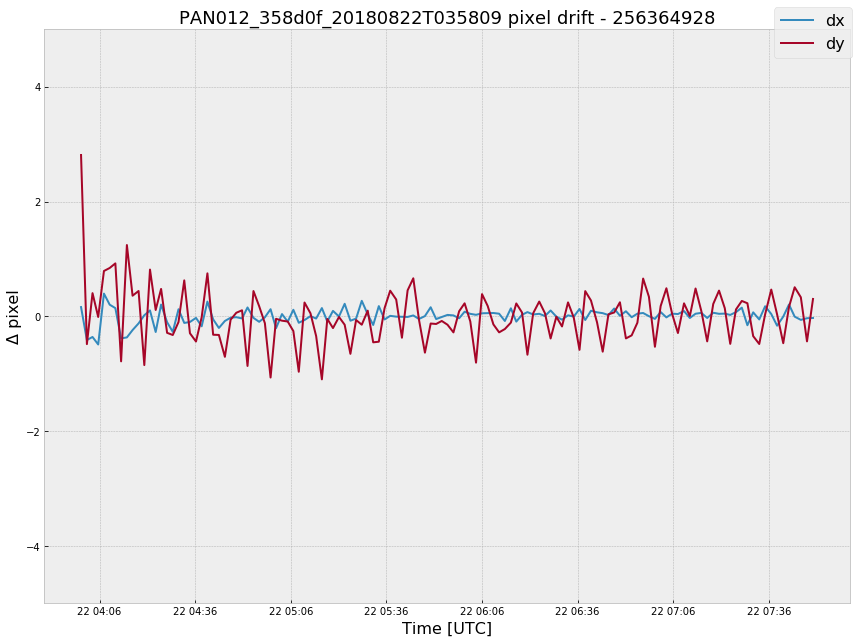

time: 4.57 s


In [25]:
# Plot the pixel drift of the target over the course of the observation.
x_pos, y_pos = helpers.get_pixel_drift(target_coords, fits_files)

out_fn = '/var/panoptes/images/temp/PAN012/target_movement_{}.png'.format(picid)

drift_pic = plot.plot_pixel_drift(
    x_pos, 
    y_pos, 
    index=image_times, 
    out_fn=out_fn,
    title='{} pixel drift - {}'.format(sequence, picid)
)
display.display(drift_pic)

### Get target data

We lookup the target PSC from our stamps file, doing a simple bias subtraction directly on the data. This should later be refined with a bias map.

In [26]:
# Simple camera bias
camera_bias = 2048 

time: 590 µs


In [27]:
# Get target PSC and subtract the bias
target_psc = pipeline.get_psc(str(picid), stamps) - camera_bias

# Get size
num_frames = target_psc.shape[0]
stamp_side = int(np.sqrt(target_psc.shape[1]))

print("N = {0} frames \nM = {2} = {1}x{1} stamps".format(num_frames, stamp_side, stamp_side**2))

N = 128 frames 
M = 100 = 10x10 stamps
time: 3.27 ms


Show an animation of the stamps.

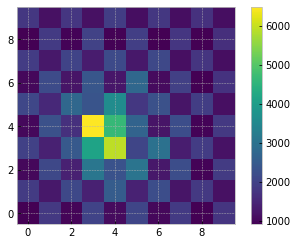

time: 227 ms


In [32]:
plt.imshow(target_psc[0].reshape(stamp_side, stamp_side))
plt.colorbar()

In [29]:
anim_fn = '/var/panoptes/images/temp/PAN012/hd189733_{}_{}.mp4'.format(sequence, picid)

if os.path.exists(anim_fn) is False:
    target_animation = plot.animate_stamp(
        target_psc.reshape(num_frames, stamp_side, stamp_side)
    )

    target_animation.save(anim_fn, dpi=150)

# display.Video(filename=anim_fn)

time: 1.28 ms


### Find similar stars

The target PSC and all source PSC are normalized on a frame-by-frame basis in order to determine the morphology of the source on an invidiual frames. The target PSC is then compared frame by frame for the entire observation sequence, returning the sum of summed squared difference of each target and source frame.

In [30]:
num_frames

128

time: 2.64 ms


In [31]:
# Removing bad frames
frame_slice = slice(1, -25)

time: 1.18 ms


In [32]:
vary_series = pipeline.find_similar_stars(picid, stamps, frame_slice=frame_slice, force_new=True)

time: 1.29 s


### Build stamp collection

We build a stamp collection of PSCs consisting of the target PSC and its `num_ref` best matches. We again take off a simple bias for each PSC as we go.

We also build a normalized version of the stamp collection.

In [34]:
num_refs = 2 # target + 100

time: 609 µs


In [35]:
# Get the target and the top-matching references
stamp_collection = np.array([
    pipeline.get_psc(str(idx), stamps, frame_slice=frame_slice) - camera_bias 
    for idx in vary_series.index[:num_refs]])

time: 3.28 ms


In [36]:
# Get target PSC (may have changed with frame_slice)
target_psc = stamp_collection[0]

num_frames = stamp_collection.shape[1]

time: 1.57 ms


In [37]:
# Get a normalized version of the entire stamp collection
normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection])

time: 2.99 ms


### Build reference coeffecients

In [38]:
# Get the coefficients the most optimally combine the normalized referenes into 
# one single master reference.
coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)

time: 3.39 ms


### Build reference PSC

In [39]:
# Use the coeffecients generated from the normalized references and
# apply them to the non-normalized (i.e. flux) stamps
ideal_psc = pipeline.get_ideal_full_psc(
    stamp_collection, 
    coeffs[0]
).reshape(num_frames, -1)

time: 1.82 ms


Animate the reference stamp similar to the target stamp

In [40]:
# Animate the ideal reference

anim_fn = '/var/panoptes/images/temp/PAN012/hd189733_{}_ref.mp4'.format(picid)

if os.path.exists(anim_fn) is False:
    ref_animation = plot.animate_stamp(
        ideal_psc.reshape(num_frames, stamp_side, stamp_side)
    )

    ref_animation.save(anim_fn, dpi=150)

    display.display(ref_animation)

time: 1.72 ms


### Show Target and reference comparison

We look at a single frame on both the target and the reference as well as the residual.

In [41]:
frame_idx = 19

time: 645 µs


In [42]:
t0 = target_psc[frame_idx].reshape(stamp_side, stamp_side)
np.argwhere(t0 == t0.max())[0]

array([4, 3])

time: 4.21 ms


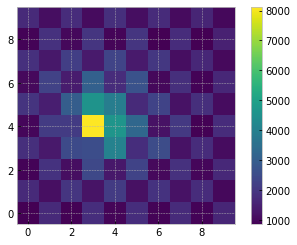

time: 245 ms


In [43]:
plt.imshow(target_psc[frame_idx].reshape(stamp_side, stamp_side))
plt.colorbar()

In [44]:
comp = pipeline.get_psc('258856132', stamps=stamps) - 2048
comp

array([[1692, 1137, 1797, ..., 1596,  861, 1635],
       [1672, 1069, 1626, ..., 1700,  877, 1588],
       [1658, 1083, 1847, ..., 1568,  845, 1566],
       ...,
       [1863,  983, 1895, ..., 1747, 1095, 1746],
       [1608,  942, 1606, ..., 1601,  872, 1624],
       [1983, 1057, 2088, ..., 1962, 1255, 1955]], dtype=uint16)

time: 5 ms


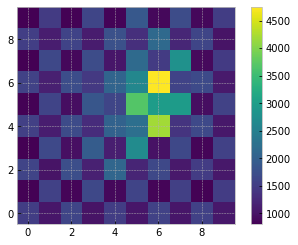

time: 246 ms


In [45]:
plt.imshow(comp[frame_idx].reshape(stamp_side, stamp_side))
plt.colorbar()

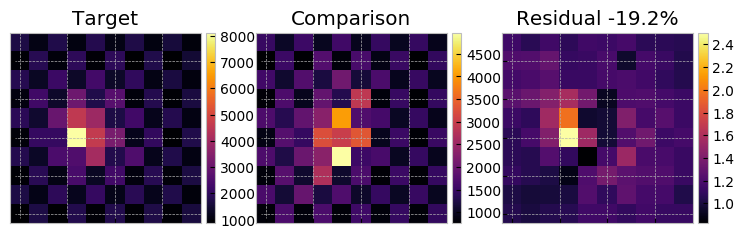

time: 741 ms


In [46]:
# Reshape into square stamps and plot the requested frame
stamp_fig = plot.show_stamps([
    target_psc.reshape(num_frames, stamp_side, stamp_side), 
    ideal_psc.reshape(num_frames, stamp_side, stamp_side)
], frame_idx=frame_idx, show_residual=True)

stamp_fig.savefig('/var/panoptes/images/temp/PAN012/target_comparison.png', dpi=150)

display.display(stamp_fig)

## Aperture photometry

Split into color channels and put an aperture around the source for both target and reference. Currently centroided by brightest pixel - needs improvement. Collect target and reference counts.

Default aperture size is 4 pixels but this should also be adaptive in some sense.

In [47]:
aperture_size = 4

time: 953 µs


In [48]:
lc0 = pipeline.get_aperture_sums(
    target_psc, 
    ideal_psc, 
    image_times, 
    aperture_size=aperture_size, 
#     subtract_back=True,
    plot_apertures=True,
    aperture_fn=os.path.join(base_dir, 'apertures_{}'.format(picid))
)

# Save the lightcurve dataframe to a csv file
# NOTE: We do this before normalizing
csv_file = os.path.join(base_dir, '{}_{}_lc.csv'.format(
    sequence.replace('/', '_'), 
    picid
))

# Save before adding relative flux
lc0.to_csv(csv_file)

lc0['rel_flux'] = sigma_clip(lc0.target / lc0.reference).filled(99)
lc0 = lc0.loc[lc0.rel_flux != 99]

lc0.head()

,color,reference,target,rel_flux
obstime,,,,
2018-08-22 04:00:12,r,4905.155195,6250,1.274170
2018-08-22 04:00:12,g,18607.045544,27241,1.464015
2018-08-22 04:00:12,b,8121.345081,10881,1.339803
2018-08-22 04:02:02,r,6264.757564,6668,1.064367
2018-08-22 04:02:02,g,23040.702008,24076,1.044933


time: 50.5 s


Get the mean of each color channel and normalize the `rel_flux` by that mean.

In [49]:
pre_ingress_flux = lc0.loc[lc0.index < ingress]
post_egress_flux = lc0.loc[lc0.index > egress]

time: 3.08 ms


In [50]:
# Get the mean for the pre-ingress for each channel
color_means = pre_ingress_flux.groupby('color').rel_flux.mean()
# color_means = lc0[lc0.rel_flux != 99].groupby('color').rel_flux.mean()

# Make a copy
lc2 = lc0.copy()

for color, mean in color_means.iteritems():
    print("{} μ={:.04f}".format(color, mean))
    
    # Get the raw values
    raw_values = lc2.loc[lc2.color == color, ('rel_flux')]
    
    mean_values = sigma_clip(raw_values / mean).filled(np.nan)
#     mean_values = mean_values[mean_values != 99]
    
    lc2.loc[lc2.color == color, ('rel_flux')] = mean_values

b μ=1.4136
g μ=1.2932
r μ=1.2298
time: 59.7 ms


In [51]:
transit_params = exoplanet.get_model_params(period=exoplanet.period.value)

time: 1.78 ms


In [52]:
for attr in dir(transit_params):
    if attr.startswith('__'):
        continue
        
    val = getattr(transit_params, attr)
    print("{:.<12s} {}".format(attr, val))

a........... 8.83602
ecc......... 0.0
fp.......... None
inc......... 85.71
limb_dark... uniform
per......... 2.21857567
rp.......... 0.15468774550850156
t0.......... 0.0
t_secondary. None
u........... []
w........... 90.0
time: 2.32 ms


σ=5.5899%


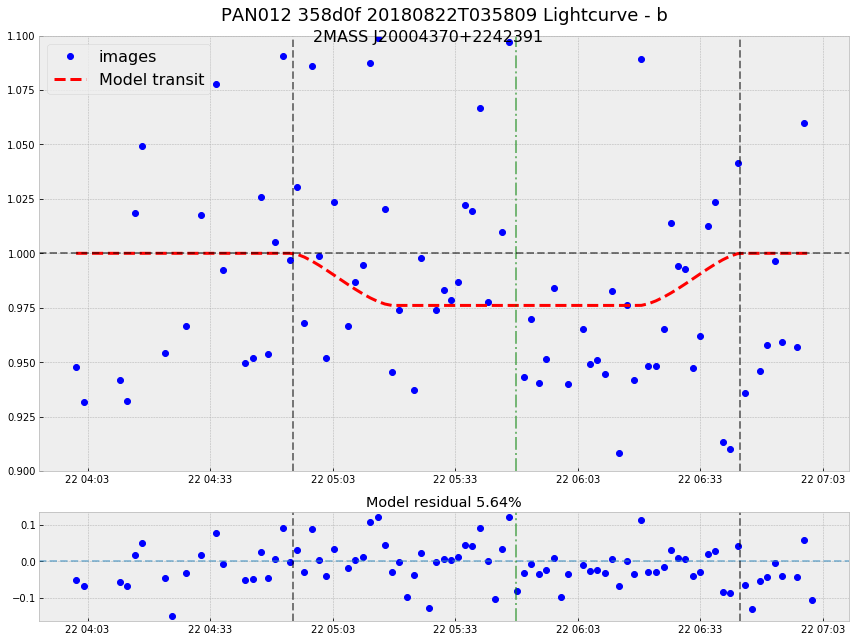

σ=13.3435%


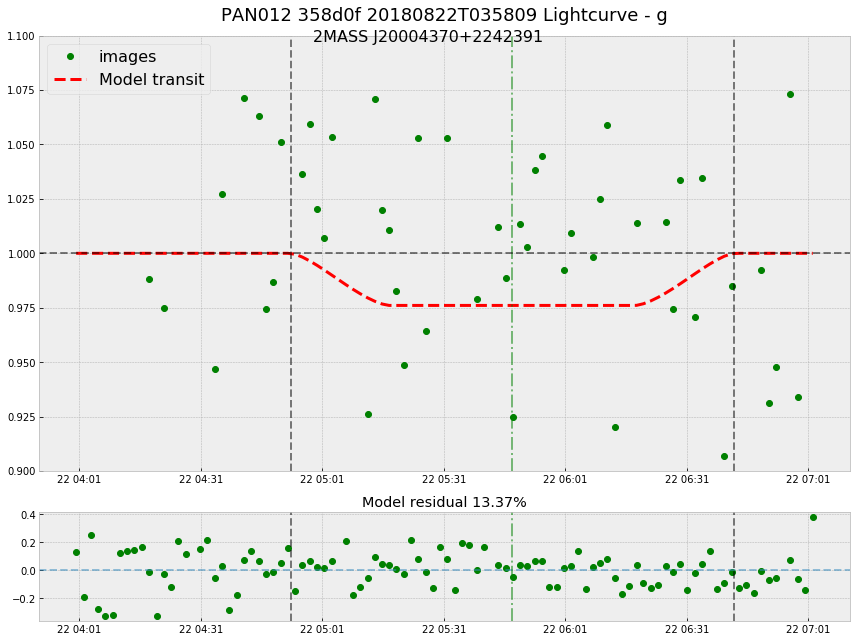

σ=10.6095%


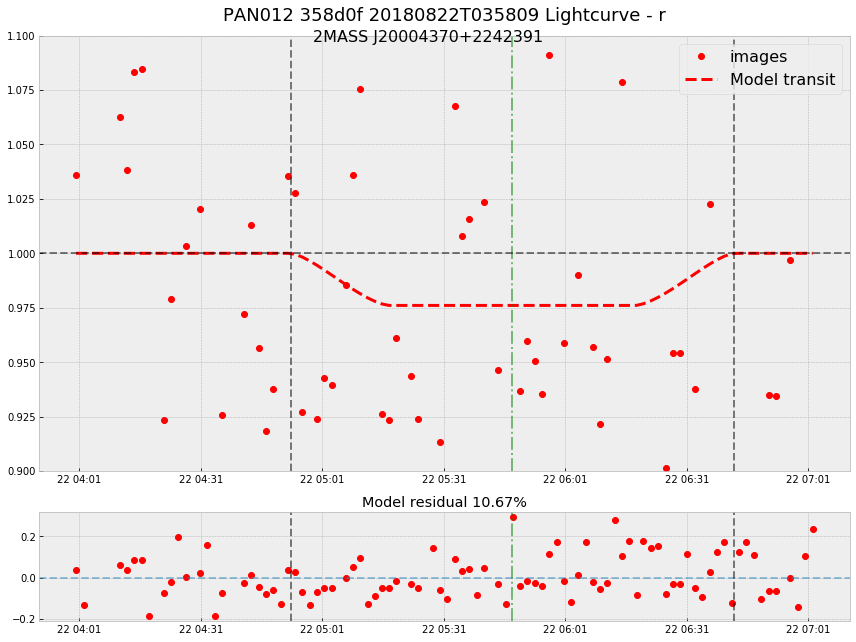

time: 4.48 s


In [53]:
for color, data in lc2.groupby('color'):
        
    y = data.loc[data.rel_flux != 99].rel_flux
    x = y.index

    # Get the orbital phase of the exoplanet
    orbital_phase = np.array([exoplanet.get_phase(Time(t0)) for t0 in x])
    base_model_flux = exoplanet.get_model_lightcurve(orbital_phase)
    
#     base_model_flux = np.ones_like(y)
    
    lc_fig = plot.plot_lightcurve(x, y, base_model_flux, 
        transit_info=[midpoint, ingress, egress],
        title="{} Lightcurve - {}".format(sequence.replace('_', ' '), color),
        ylim=[.9, 1.1], 
        color=color
    )    
    
    print('σ={:.04%}'.format(y.std()))
    
    # Show the 2MASS ID
    tmid = stamps[picid].attrs['twomass']
    lc_fig.suptitle('2MASS J{}'.format(tmid), y=0.95, fontsize=16)    
    
    display.display(lc_fig)
    
    lc_fig.savefig('/var/panoptes/images/temp/PAN012/final_lc_{}_{}.png'.format(picid, color), 
               dpi=150, transparent=False)

### Combined color channels

In [54]:
# We are using all color channels combined for now
# lc1pre = lc0.loc[lc0.color != 'r']
# lc1 = lc1pre.groupby('obstime').sum()
lc1 = lc0.groupby('obstime').sum()

# Redo the relative flux with new sums
lc1['rel_flux'] = sigma_clip(lc1.target / lc1.reference).filled(99)

lc1 = lc1.loc[lc1.rel_flux != 99]

pre_ingress_flux = lc1.loc[lc1.index < ingress].rel_flux
post_egress_flux = lc1.loc[lc1.index > egress].rel_flux

# Normalize the entire observation relative flux by the pre-ingress mean
# lc1['rel_flux'] = sigma_clip(lc1.rel_flux / pre_ingress_flux.mean()).filled(99)

# Normalize by the mean
lc1['rel_flux'] = sigma_clip(lc1.rel_flux / lc1.rel_flux.mean()).filled(1)

lc1 = lc1.loc[lc1.rel_flux != 99]

# Show top entries
lc1.head()

,reference,target,rel_flux
obstime,,,
2018-08-22 04:00:12,31633.545820,44372,1.084403
2018-08-22 04:02:02,37445.429343,41466,0.856097
2018-08-22 04:03:48,19920.576312,32067,1.244475
2018-08-22 04:10:58,31257.131033,43742,1.081880
2018-08-22 04:12:46,31164.987830,43665,1.083169


time: 129 ms


Get both the time delta (in days) as well as the orbital phase of the exoplanet.

In [55]:
# Get the time offsets as the delta (in days) from the midpoint
delta_days_before = [
    -1 * ((midpoint - t0).seconds * u.second).to(u.day).value 
    for t0 in lc1.index if t0 < midpoint
]

delta_days_after = [
    ((t0 - midpoint).seconds * u.second).to(u.day).value 
    for t0 in lc1.index if t0 >= midpoint
]

delta_days = np.array(delta_days_before + delta_days_after)

# Get the orbital phase of the exoplanet
orbital_phase = np.array([exoplanet.get_phase(Time(t0)) for t0 in lc1.index])

time: 596 ms


### Plot lightcurve

In [56]:
base_model_flux = exoplanet.get_model_lightcurve(orbital_phase)

time: 2.72 ms


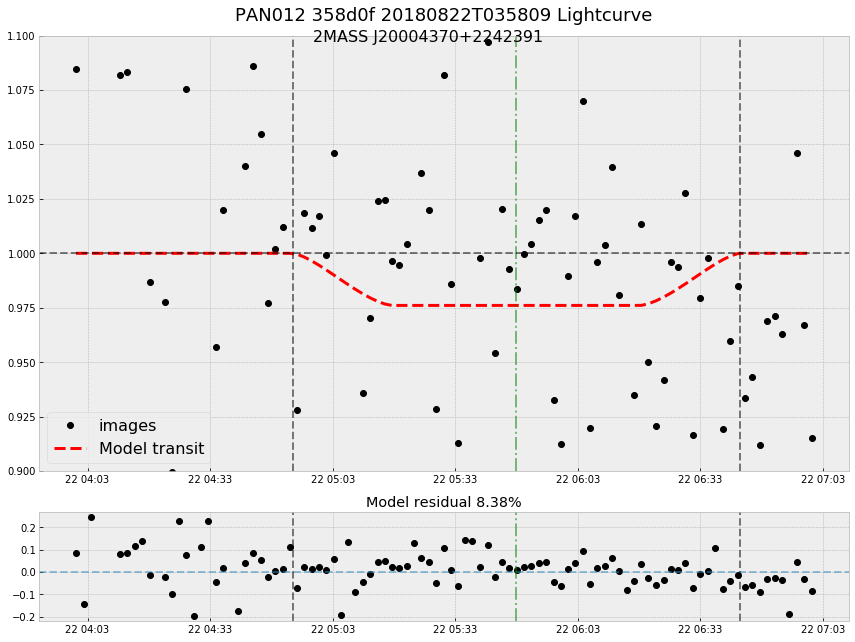

time: 973 ms


In [57]:
# Plot the lightcurve

x = lc1.index
y = lc1.rel_flux

# base_model_flux = np.ones_like(lc1.rel_flux.values)

lc_fig = plot.plot_lightcurve(x, y, base_model_flux, 
    transit_info=[midpoint, ingress, egress],
    title="{} Lightcurve".format(sequence.replace('_', ' ')),
    ylim=[.9, 1.1]
)

# Show the 2MASS ID
tmid = stamps[picid].attrs['twomass']
lc_fig.suptitle('2MASS J{}'.format(tmid), y=0.95, fontsize=16)

# box_text = 'σ = {:.05}'.format(lc1.rel_flux.std())
# ob = offsetbox.AnchoredText(box_text, loc=1, prop=dict(size=12, family="monospace"))
# ob.patch.set(boxstyle='square,pad=0.2', alpha=0.85)
# lc_fig.axes[1].add_artist(ob)

# Add some properties
# ob = offsetbox.AnchoredText(props, loc=2, prop=dict(size=12, family="monospace"))
# ob.patch.set(boxstyle='square,pad=0.2', alpha=0.85)
# lc_fig.axes[0].add_artist(ob)

# lc_fig.axes[0].plot(lc1.index, model_flux, c='r', ls='--', label='Transit fit')
# lc_fig.axes[0].legend()

# residual = lc1.rel_flux - model_flux
# lc_fig.axes[1].plot(lc1.index, residual, c='r', ls='', marker='x', label='Fit {:.04f}'.format(residual.std()))
# lc_fig.axes[1].legend(loc=1, fontsize=14)

lc_fig.savefig('/var/panoptes/images/temp/PAN012/final_lc_fit_{}.png'.format(picid), 
               dpi=150, transparent=False)

display.display(lc_fig)

---